In [1]:
import torch
import requests
from PIL import Image
from datasets import load_dataset
from transformers import BlipProcessor, BlipForConditionalGeneration
from torch.optim import AdamW

c:\Projects\image-captioning-conceptual-captions\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("conceptual_captions", split="train[:200]")

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-base"
).to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
model.train()
optimizer = AdamW(model.parameters(), lr=5e-5)

In [5]:
import requests
from PIL import Image

model.train()

for i in range(len(dataset)):
    sample = dataset[i]

    try:
        image = Image.open(
            requests.get(sample["image_url"], stream=True, timeout=5).raw
        ).convert("RGB")
    except Exception as e:
        print("Skipping image due to error:", e)
        continue

    caption = sample["caption"]

    inputs = processor(
        images=image,
        text=caption,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(device)

    outputs = model(**inputs, labels=inputs["input_ids"])
    loss = outputs.loss

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print("Training loss:", loss.item())
    break

Skipping image due to error: HTTPConnectionPool(host='lh6.ggpht.com', port=80): Max retries exceeded with url: /-IvRtNLNcG8o/TpFyrudaT6I/AAAAAAAAM6o/_11MuAAKalQ/IMG_3422.JPG?imgmax=800 (Caused by NewConnectionError("HTTPConnection(host='lh6.ggpht.com', port=80): Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it"))
Training loss: 4.4826836585998535


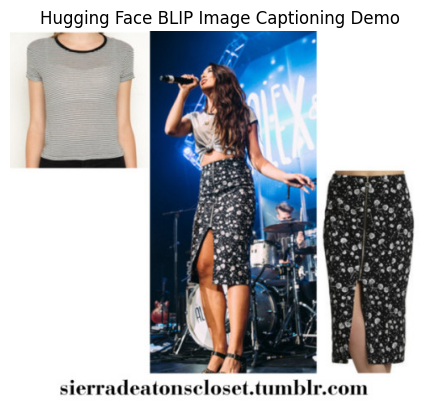

Caption: person in this top and skirt


In [7]:
import matplotlib.pyplot as plt
import requests
from PIL import Image

model.eval()

for i in range(len(dataset)):
    sample = dataset[i]
    try:
        image = Image.open(
            requests.get(sample["image_url"], stream=True, timeout=5).raw
        ).convert("RGB")
        break
    except:
        continue

inputs = processor(images=image, return_tensors="pt").to(device)
output = model.generate(**inputs, max_length=30)
caption = processor.decode(output[0], skip_special_tokens=True)

plt.imshow(image)
plt.axis("off")
plt.title("Hugging Face BLIP Image Captioning Demo")
plt.show()

print("Caption:",caption)